In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
import os
import re
pd.options.display.max_colwidth = 400
import nltk.corpus
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

In [3]:
df = pd.read_csv("/Users/niklashemmer/PycharmProjects/Webscraping/tielemans_general.csv")

# Drop NaN values and unnecessary columns
df.drop(["Unnamed: 0", "User"], axis=1, inplace=True)
df.dropna(inplace=True)
df.head()

,Username,PostCount,Date,Comment
0,StriderHiryu,"9,734",13/09/20 14:45,"For me the man of the match. Ran the show, got stuck in where needed, dictated the tempo of the game. The frightening thing is despite all of that, I would probably ""only"" give him an 8/10. He's capable of getting even better. He had to turn up today, and he did and then some."
1,Corky,"48,848",13/09/20 14:47,"Bloke is absolute class, if he's fit and firing we tick."
2,StanSP,"65,318",13/09/20 14:48,A 3 starting midfielders helped dominate the game today after 25 mins. Praet or Mendy more so for MOTM but can't deny Youri's contribution!
3,matty98,"2,542",13/09/20 14:48,Clearly worked on his fitness alot during the break. Looks back to his best!
4,Ric Flair,"44,092",13/09/20 14:50,Star man


# 1. Preprocessing the Data

We will start by preparing the data. Some of this is done automatically with certain libraries, but we will walk through each step briefly. We will take the following steps.

1. Tokenization: Tokenization breaks up sentences into words. "Tielemans is a good footballer" becomes ["Tielemans", "is", "a", "good", "footballer"]
2. Removal of stopwords: We remove all words that have very little semantic information or no meaning at all such as "the", "a", "and", etc. 
3. POS-Speech: After creating the tokens, we can tag each word based on its grammatical category (noun, verb, adjective, etc.)
4. Lemmatization: Lemmatization removes all affixes. For example, giving, gave and given become "give" 

In [4]:
# Variety of users 
users = df.groupby("Username")["Comment"].count().sort_values(ascending=False).reset_index()
users[users["Comment"] <= 2]["Username"].count()

337

In [5]:
def get_wordnet_pos(pos_tag):
    """Assign grammatical category to each word"""
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [6]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = nltk.word_tokenize(text)
    # remove words that contain numbers
    #text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = nltk.pos_tag(text)
    # lemmatize text
    # It takes in text and lemmatizes each word of the text based on its POS tag if it is present and then returns the lemmatized text back
    # Therefore, it is important to assign POS tags to the token before
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags] # 
    # remove words with only one letter (would be smilys, questionnaires etc.)
    #text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [7]:
df["Comment_clean"] = df["Comment"].apply(lambda x: clean_text(x))
df.head(2)

,Username,PostCount,Date,Comment,Comment_clean
0,StriderHiryu,"9,734",13/09/20 14:45,"For me the man of the match. Ran the show, got stuck in where needed, dictated the tempo of the game. The frightening thing is despite all of that, I would probably ""only"" give him an 8/10. He's capable of getting even better. He had to turn up today, and he did and then some.","man match . run show , get stick need , dictate tempo game . frighten thing despite , would probably `` '' give 8/10 . 's capable get even well . turn today , ."
1,Corky,"48,848",13/09/20 14:47,"Bloke is absolute class, if he's fit and firing we tick.","bloke absolute class , 's fit firing tick ."


# 2. Text Classification 

### 2.1 Sentiment Analysis 

One of the most common techniques of text classification is sentiment analysis. In general, social media, surveys, and feedback data all are heavily opinionated and express the beliefs, emotions, and feelings of human beings. Sentiment analysis uses machine learning techniques to extract information and classify a message's sentiment into positive, negative, or neutral.

We will be using the Vader Sentiment lexicon, a package of the popular NLTK library, which stands for Valence Aware Dictionary and Sentiment Reasoner. It is a lexicon with a rule-based sentiment analysis framework that was specifically built for analyzing sentiment from social media resources. Each word or emoticon is rated on a scale from -4 (extremely negative) to +4 (extremely positive), providing input for the final "compound" score.

In [8]:
# Add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create a function to get the Vader Sentiment 
def sentiment_vader(text):
    
    analyzer = SentimentIntensityAnalyzer()
    vs_polarity = analyzer.polarity_scores(text)
    
    return vs_polarity

In [9]:
df["Vader Polarity"] = df["Comment_clean"].apply(sentiment_vader)
df = pd.concat([df.drop(['Vader Polarity'], axis=1), df['Vader Polarity'].apply(pd.Series)], axis=1)
df.head()

,Username,PostCount,Date,Comment,Comment_clean,neg,neu,pos,compound
0,StriderHiryu,"9,734",13/09/20 14:45,"For me the man of the match. Ran the show, got stuck in where needed, dictated the tempo of the game. The frightening thing is despite all of that, I would probably ""only"" give him an 8/10. He's capable of getting even better. He had to turn up today, and he did and then some.","man match . run show , get stick need , dictate tempo game . frighten thing despite , would probably `` '' give 8/10 . 's capable get even well . turn today , .",0.080,0.764,0.156,0.3182
1,Corky,"48,848",13/09/20 14:47,"Bloke is absolute class, if he's fit and firing we tick.","bloke absolute class , 's fit firing tick .",0.242,0.505,0.253,0.0258
2,StanSP,"65,318",13/09/20 14:48,A 3 starting midfielders helped dominate the game today after 25 mins. Praet or Mendy more so for MOTM but can't deny Youri's contribution!,3 start midfielders help dominate game today 25 min . praet mendy motm ca n't deny youri 's contribution !,0.073,0.682,0.245,0.5466
3,matty98,"2,542",13/09/20 14:48,Clearly worked on his fitness alot during the break. Looks back to his best!,clearly work fitness alot break . look back best !,0.000,0.350,0.650,0.8516
4,Ric Flair,"44,092",13/09/20 14:50,Star man,star man,0.000,1.000,0.000,0.0000


In [10]:
df.sort_values(by="compound", ascending = True)[0:10]

,Username,PostCount,Date,Comment,Comment_clean,neg,neu,pos,compound
4091,Sampson,"4,478",19/01/22 23:07,"It's not a strawman and it is ""literally"", you were responding to my quote saying ""why can't people just accept when Tielemans is in form rather than talking about the system or the players around him"" with a literal and black and white post about the system and the players around him.\n\n\tIt's not a strawman, unless you are deliberately misinterpreting my post and trying to strawman my origi...","'s strawman `` literally '' , respond quote say `` ca n't people accept tielemans form rather talk system player around '' literal black white post system player around . 's strawman , unless deliberately misinterpret post try strawman original argument . 's simple question : choudhury centre-back `` absurd selection '' player misplace simple pass player space ? poor tonight nothing `` overrun...",0.211,0.768,0.021,-0.9830
4747,hejammy,"4,416",20/04/22 21:28,"Like some others have said, yes we understand that part of his game is trying that difficult pass etc BUT he's been awful in all areas, not just giving the ball away (which he's doing much more often now then a few months back) he's too slow, lathergic, doesn't track his runners, doesn't go in for 50/50s, doesn't ever win a header, positionally he's become poor and his shooting had shot to pei...","like others say , yes understand part game try difficult pas etc 's awful area , give ball away ( 's much often month back ) 's slow , lathergic , n't track runner , n't go 50/50s , n't ever win header , positionally 's become poor shoot shot peices . 's take risk obviously 'll give ball away often . compare month back 's awful account .",0.265,0.663,0.072,-0.9181
3114,SecretPro,"5,945",03/10/21 15:00,"Shit today, massively shit. Literally the worst player on the pitch. All very strange","shit today , massively shit . literally bad player pitch . strange",0.714,0.286,0.000,-0.9100
2389,Blarmy,709,30/05/21 16:33,"I looked it up. Dead wood is useless wood dead on the tree, hence the term for somebody or something that needs to be removed.","look . dead wood useless wood dead tree , hence term somebody something need remove .",0.533,0.467,0.000,-0.9081
4624,StanSP,"65,318",17/04/22 15:33,Bloody hell he's not that bad.,bloody hell 's bad .,0.917,0.083,0.000,-0.9001
4080,Sampson,"4,478",19/01/22 22:46,This is exactly the shit I was talking about. He was shit because he was making shit simple passes.,exactly shit talk . shit make shit simple pass .,0.684,0.316,0.000,-0.8957
4062,shen,"13,682",19/01/22 22:31,"5 goals in 15 games this season just is not 'poor'. He's maybe had some games where his level has been lower than usual, but overall it's stupid to call his season poor.","5 goal 15 game season 'poor ' . 's maybe game level low usual , overall 's stupid call season poor .",0.474,0.526,0.000,-0.8934
3354,ParkerPen,597,16/10/21 20:06,"he's damned if he does, damned if he doesnt. \n\n\tunited have a paucity of talent to play a 2 man midfield, and playing a three wrecks their formation. what a shame","'s damn , damn doesnt . united paucity talent play 2 man midfield , play three wreck formation . shame",0.577,0.251,0.172,-0.8824
4876,Collymore,"10,760",08/05/22 21:36,"He was so bad today I thought it was perhaps the atmosphere and murmurings getting to him. Happens to me at 5 aside when some of the lads get on my back for 1 or 2 poor passes, I go to shit.","bad today think perhaps atmosphere murmuring get . happen 5 aside lad get back 1 2 poor pass , go shit .",0.440,0.560,0.000,-0.8807
2170,UniFox21,"14,535",25/05/21 08:01,Damn that explains a lot. Always find it disappointing when someone at the club turns out to be a massive dickhead.,damn explain lot . always find disappointing someone club turn massive dickhead .,0.556,0.444,0.000,-0.8750


In [11]:
# Convert the date column to datetime values (funktioniert nicht)
df['Date'] = pd.to_datetime(df['Date'])
df['Date1'] = df['Date'].dt.strftime('%Y-%m')

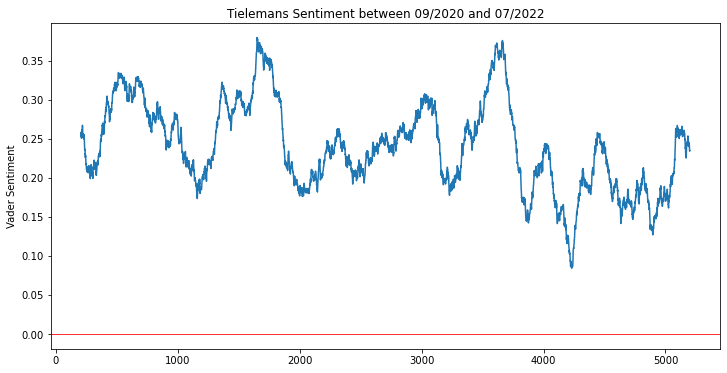

In [12]:
#df = df.sort_values(by="cumcount")
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df.rolling(200)["compound"].mean())
ax.set_ylabel("Vader Sentiment")
#ax.set_xlabel("cumcount")
ax.set_title("Tielemans Sentiment between 09/2020 and 07/2022")
ax.axhline(0, color='red', linewidth=0.8)

In [13]:
#greater than the start date and smaller than the end date
mask = (df['Date'] > "2022-01-01") & (df['Date'] <= "2022-03-01")
df.loc[mask].sort_values(by="compound", ascending=True)[["Date", "Comment", "compound"]].head(10)

,Date,Comment,compound
4091,2022-01-19 23:07:00,"It's not a strawman and it is ""literally"", you were responding to my quote saying ""why can't people just accept when Tielemans is in form rather than talking about the system or the players around him"" with a literal and black and white post about the system and the players around him.\n\n\tIt's not a strawman, unless you are deliberately misinterpreting my post and trying to strawman my origi...",-0.9830
4080,2022-01-19 22:46:00,This is exactly the shit I was talking about. He was shit because he was making shit simple passes.,-0.8957
4062,2022-01-19 22:31:00,"5 goals in 15 games this season just is not 'poor'. He's maybe had some games where his level has been lower than usual, but overall it's stupid to call his season poor.",-0.8934
4109,2022-01-20 00:00:00,"I could be wrong, but he just doesn't seem like the kind of character who would mail it in.",-0.7897
4029,2022-01-19 21:47:00,Worst game for us. Gave the ball away so often in stupid situations.,-0.7845
4820,2022-01-05 12:43:00,How long into the Roma game are we giving it until someone moans taking Tielemans out today was a bad idea because he’s lost his rythem / match sharpness,-0.7783
4057,2022-01-19 22:26:00,You can tell he's livid and disappointed with Youri.,-0.7351
4034,2022-01-19 21:53:00,At fault for the 3rd. Sloppy in possession all game. Very disappointing.,-0.7096
4104,2022-01-19 23:49:00,"He's got quite an expressionless face. That coupled with the fact he's very slow and unathletic can often lead people to think he's not trying, or his heart is not in it. Which I don't think is the case. He's always had the odd stinker. Tonight's performance shouldn't really surprise anyone.",-0.7032
4043,2022-01-19 22:05:00,"He was. He gave away 2 penalties, was at fault for a further 2 goals and I think gave ManCity even more free counter attacks than he gave Spurs tonight.",-0.6705


### 2.2 Topic Modeling: Latent Dirichlet Allocation

In [14]:
import gensim
from gensim.utils import simple_preprocess

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [16]:
data = df["Comment_clean"].values.tolist()
data_words = list(sent_to_words(data))

In [17]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]


In [18]:
from pprint import pprint

# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"think" + 0.013*"season" + 0.012*"game" + 0.011*"player" + '
  '0.010*"youri" + 0.010*"play" + 0.010*"go" + 0.010*"one" + 0.009*"year" + '
  '0.009*"get"'),
 (1,
  '0.019*"player" + 0.016*"play" + 0.012*"like" + 0.010*"time" + 0.010*"get" + '
  '0.010*"think" + 0.009*"game" + 0.009*"youri" + 0.009*"say" + 0.008*"club"'),
 (2,
  '0.023*"get" + 0.017*"think" + 0.013*"go" + 0.010*"would" + 0.009*"player" + '
  '0.008*"game" + 0.008*"season" + 0.008*"like" + 0.008*"even" + 0.007*"see"'),
 (3,
  '0.015*"get" + 0.013*"think" + 0.011*"good" + 0.011*"player" + 0.009*"would" '
  '+ 0.009*"sign" + 0.009*"one" + 0.009*"season" + 0.008*"youri" + '
  '0.008*"contract"'),
 (4,
  '0.020*"player" + 0.015*"go" + 0.012*"good" + 0.012*"youri" + 0.011*"club" + '
  '0.010*"well" + 0.010*"season" + 0.009*"tielemans" + 0.008*"would" + '
  '0.007*"see"')]


In [19]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('/Users/niklashemmer/Documents'+str(num_topics))

# this is a bit time consuming - make the if statement True
# if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

#pyLDAvis.save_html(LDAvis_prepared, '/Users/niklashemmer/Documents'+ str(num_topics) +'.html')

#LDAvis_prepared

/Users/niklashemmer/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/niklashemmer/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niklashemmer/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niklashemmer/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niklas

# 3. Text Extraction

### 3.1 Word Frequency 

Keyword extraction automatically extracts the most used and most important words and expressions from a text. It helps summarize the content of texts and recognize the main topics discussed.

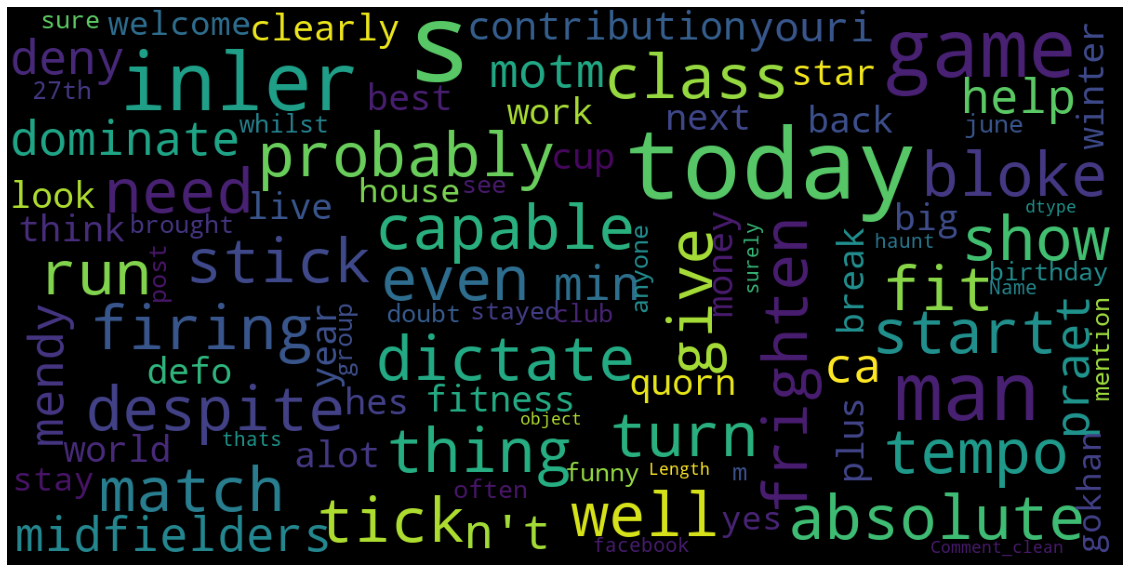

In [20]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["Comment_clean"])

There's nothing suspicious in these keywords. They are all fairly neutral or even positive. If we view keyword extraction as some sort of Due Diligence that is supposed to highlight any flaws, we can explicitly look at wordcloud that summarizes negative comments (negative sentiment)

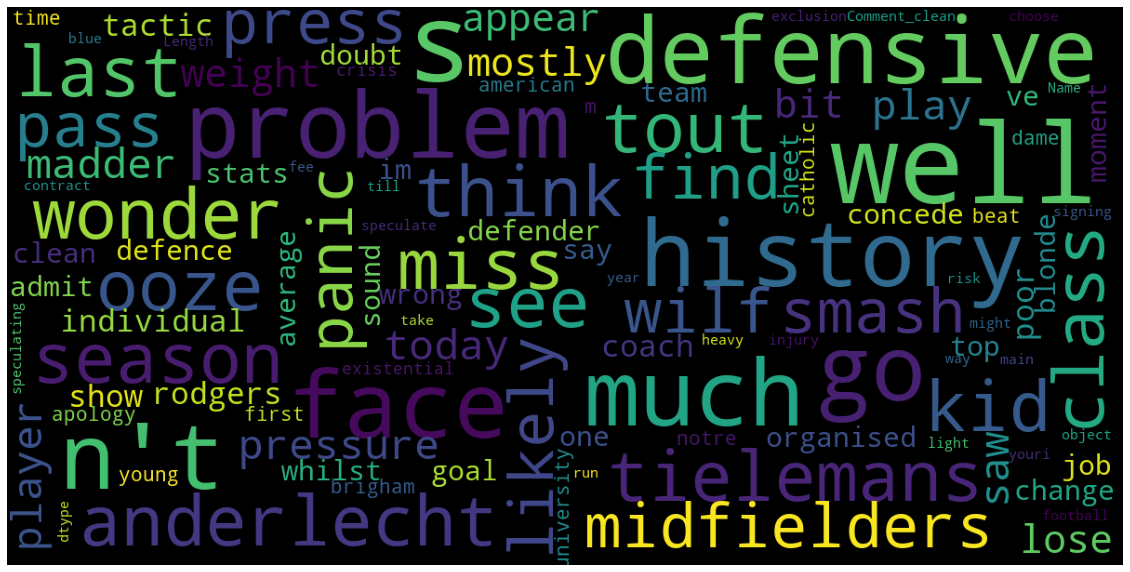

In [21]:
# Create DataFrame only with negative sentiment
neg = df[df["compound"] < 0]

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(neg["Comment_clean"])

One point of discussion seems to be his weight. It's at least a word that's highlighted, so it might be worth looking at. However, as we see below, fans are not really concerned about his weight. 

We could proceed similarly for all keywords that seem strange or concerning. We could also do it for words that we just have in our mind like "partying"

In [22]:
neg[neg["Comment"].str.contains("weight")][["Comment", "Date"]]

,Comment,Date
59,It appears he’s lost a bit of weight.,2020-09-20 20:43:00
108,I was sceptical that he has lost weight. I used to think the weight thing was just something to moan at and that was just his build. Also his distance covered last season per game was very high.,2020-09-27 21:15:00
123,"It's all down to the weight he's lost imo, which I have been shouting at him a long time about.",2020-09-28 08:11:00
173,"Felt sorry for him yesterday, basically our whole attack rested on him, while he was also having to pull his weight in a two man midfield. Was blowing out his arse by about 70 minutes though which was concerning given how much of the ball we had in the second half. That video of him trying to run when Rice hit the bar is a painful watch.",2020-05-10 07:39:00
1990,I’d hate to see us lose Tielemans. He’s the only properly creative player we have and those players are worth their weight on gold. \n\t‘It would be a sad day for LCFC,2021-05-23 21:27:00


One problem with posts in fan forums is that many comments are not very insightful. In that sense, these forums are similar to Twitter: You don't think too deeply about something but just post it. 

To focus on "real" opinions, we can introduce a constraint with regard to the number of words. This allows us to filter comments that contain more than just an adjective but more likely real sentences.

In [35]:
# Add number of words column 
df["words"] = df["Comment"].apply(lambda x: len(x.split(" ")))

In [36]:
# Get Comments with negative sentiment
df[df["words"] > 30].sort_values(by="neg", ascending=False)[["Comment", "compound", "Username"]].head(10)

,Comment,compound,Username
4725,The problem in this team isn’t Tielemans ffs! It’s some kind of weak mental attitude that results in us shitting our pants during the latter stages of matches. That comes from the manager.,-0.8718,Col city fan
4062,"5 goals in 15 games this season just is not 'poor'. He's maybe had some games where his level has been lower than usual, but overall it's stupid to call his season poor.",-0.8934,shen
4168,I don't care how good a player you are if you don't wanna be here just pipe up say and leave cause the performances from him past few months have been horrendous and it's clear he doesn't have the same care he once did.,-0.8427,brockmyster
4876,"He was so bad today I thought it was perhaps the atmosphere and murmurings getting to him. Happens to me at 5 aside when some of the lads get on my back for 1 or 2 poor passes, I go to shit.",-0.8807,Collymore
1990,I’d hate to see us lose Tielemans. He’s the only properly creative player we have and those players are worth their weight on gold. \n\t‘It would be a sad day for LCFC,-0.6908,Col city fan
3390,"Rodgers was asked about him and he said he'd asked to come off as he was injured but they ignored him and made him carry on. If he dies, he dies or something like that. Unbelievable",-0.7003,Ric Flair
4983,"IMO, it is unfair to say his performance is bad because he actaully doing Ndidi job many times. And BR plan is to make him more on defensive side and Maddison on offensive side. No fair to compare him with Madders directly.",-0.8555,Angus Sze
5099,"Exactly my view. He's been played deep a lot of this season and he does it well, but it really isn't where we see the best of him. He plays best higher up the pitch.",-0.7003,Foxhateram
3982,"When the going gets tough, Youri often disappears. That is nothing new and prospective buyers will be seriously unimpressed. You can't always be at your best but at least you can battle like KDH for instance.",-0.6351,An Sionnach
1210,That’s what ‘game changers’ can do and that’s why they are so sought after. Maddison is another one. He’ll be having a shocker and then he’ll pop up with something that makes us all think wtf!,-0.6900,Col city fan


In [37]:
df[df["words"] > 30].sort_values(by="pos", ascending=False)[["Comment", "compound", "Username"]].head(10)

,Comment,compound,Username
145,One of the best to have played for our club. He seems to enjoy it at Leicester and be happy in the local so hopefully we get him for a few more years.,0.9451,Freeman's Wharfer
3601,"Yeah greatest ever to play for us in terms of talent(more talented than Kante and Vardy). There is more to being the best ever than just talent though. Vardy is the greatest to ever play for us and Kante for me plainly for such an unbelievable season are above Youri as greatest ever Leicester player, but does that mean he cant be the greatest in terms of talent despite this?",0.9906,deanolegend1989
1464,I love Youri and he has had a great season but I think that our saving grace is that he is just a fraction short of being good enough for the European giants.,0.9531,murphy
4446,I believe so as well. Seems like a natural fit for both parties. Would wish him the best if he went there. Think he’d thrive even more in the slower paced Série A as well.,0.9601,Foxes96
1522,"I agree with everything that has been said, but he has the luxury of the excellent Wilf which enables him to play as he wants! As a pair there are few better!",0.8906,ferry67
3553,Natural talent wise I think he might be the best to ever play for us. Vardy has had to work extremely hard to reach his level whereas I think Youri is just a natural,0.9450,foxfanazer
2497,"But where does this statement come from? How do you know he wants to go? Allegedly he is very happy here, his family is happy and settled here and that is important to him?",0.8762,hejammy
209,"I agree we were far too nice last season, while I don’t like these tactical fouls it is to the benefit of the team, and a lot of teams even the best sides do it.",0.9325,foxes_rule1978
4683,"He's had a good fun here. Some great times, great goals and some elite displays. His heart isn't in it anymore.. He will continue to play because he's still capable of invention and creative foward passes",0.9694,Koke
2953,"I think he's terrific but I'm sure he wants to move. The way the top 4 are spending, Champions League isn't likely and you can't blame him for wanting more money if the opportunity arises. Hopefully they can get a fee for him - and most importantly replace him.",0.9614,TeaMen Tom


## 3.2 TF-IDF (Scikit)

TF-IDF is a necessary pre-processing step for machine learning techniques like clustering, topic modeling and text classification. Here, however, we only use it to extract important keywords from our comments. These keywords can be used a summary of individual documents/posts or, as we aim for here, to look at the keywords in aggregate and extract the most important ones.

In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

We would usually start by performing some pre-processing steps again. However, we have already performed this step in the beginning, so we can jump directly to the creation of the IDF.

### Creating the TF 

We are now going to create a sparse matrix, i.e. a matrix in which most elements are zero. Each column represents a word and each row represents a post of our dataset. The values of each cell show the raw frequency of each word in a post dividided by the number of words in a post. 

For example: Tielemans is a good player --> The TF for Tielemans would be 1/5. 

In [199]:
# Create a vocabulary of words and eliminate stop words
cv = CountVectorizer(stop_words = stopwords)

text = df["Comment_clean"].tolist()

count_vector = cv.fit_transform(text)
#tfidf_result = tfidf.fit_transform(df["Comment_clean"]).toarray()

/Users/niklashemmer/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'think', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn(


In [200]:
count_vector.shape

(4939, 6016)

The shape is (4939, 6016) because we have 4.939 comments/posts in our dataset (rows) and the vocabulary size is 6,016, i.e. we have 6,016 unique words (column) in our dataset, not including stopwords.

We can reduce the size of our vocabulary by setting constraints. For example, we can only include words that appear a certain number of times. In addition, we can exclude words that appear in 50% of all comments

In [201]:
# min df cuts off all words that are mentioned fewer times 
# max df cuts of all words that are mentioned in 50% of all comments
cv = CountVectorizer(min_df = 2, max_df = 0.5, stop_words = stopwords)
count_vector = cv.fit_transform(text)
count_vector.shape

(4939, 3068)

We have reduced the size of our vocabulary by almost 50% (all due to the constraint that the word has to appear at least twice). Now we can look at some of the vocabularies in our dataset.

In [202]:
list(cv.vocabulary_.keys())[:10]

['man',
 'match',
 'run',
 'show',
 'stick',
 'need',
 'dictate',
 'tempo',
 'game',
 'frighten']

In [203]:
list(cv.get_feature_names())[2000:2015]

/Users/niklashemmer/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['persist',
 'person',
 'personal',
 'personally',
 'personnel',
 'perspective',
 'persuade',
 'peter',
 'pfa',
 'phase',
 'phenomenal',
 'photo',
 'photoshopped',
 'physical',
 'physicality']

### Computing Inverse Document Frequency

Inverse Document Frequency takes the number of comments (4,939) and divides it by the number of sentences containing a specific word. For example, if Tielemans appears in 1,000 comments, the IDF would be rougly 5 (4,939/1,005). It then takes the log of the results: log(5) = 1.61 

By doing that it tells us how rare or common a word is. Tielemans is probably a very commond word whereas Ndidi might be less common. 

In [204]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(count_vector)

TfidfTransformer()

In [205]:
tfidf_transformer.idf_

array([7.42567907, 8.40650832, 5.4446776 , ..., 7.55921046, 7.42567907,
       8.40650832])

### Computing TF-IDF and extracting keywords

We've calculated both parts: TF and IDF. Now we are set to multiply these values and extract the top keywords

- sort_coo: The function receives a matrix as its input. It then aggregates the column index and the according TF-IDF score to create a tuple. It returns the tuples in descending order based on TD-IDF scores
- extract_topn: The function receives the following inputs: feature_names are all words and sorted_items is a matrix with TF-IDF scores

In [206]:
def sort_coo(coo_matrix):
    """sort values while preserving the column index"""
    tuples = zip(coo_matrix.col, coo_matrix.data)
    # Ensures that is sorted based on the TF-IDF value (x[1], not the index number)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    # Iterates over zip object
    for idx, score in sorted_items:
        # Chooses one features after another --> feature_names[1], feature_names[2], etc.
        fname = feature_names[idx]
        
        # Take each feature name (word) and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    # Create a tuples of feature,score
    # Results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

Since we want the keywords for all posts on aggregate, we can 

In [207]:
s = ' '.join(str(x) for x in df["text"])
#s

- We are now going to calculate the TF-IDF values in only one line of code. To do that, we use the Count Vectorizer and the Tfidf Transformer we initiated. This gives us a matrix in which one row like this (0, 4500): 0.0021 
- After that, we sort the items based on its TF-IDF scores in descending order

In [208]:
# Get the features names (all words)
feature_names = cv.get_feature_names()

# Choose a documents that we want to extract keywords from
comments = s

# Generate TF-IDF value
tfidf_vector = tfidf_transformer.transform(cv.transform([comments]))

# Sort the tf-idf vectors by descending order of scores
sorted_items = sort_coo(tfidf_vector.tocoo())

# Extract top keywords
keywords=extract_topn(feature_names,sorted_items,10)

In [209]:
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


===Keywords===
just 0.392
here 0.196
think 0.19
youri 0.181
season 0.17
like 0.156
player 0.142
tielemans 0.133
playing 0.125
club 0.119


### Generate keywords for multiple documents

In [210]:
tf_idf_vector = tfidf_transformer.transform(cv.transform(text))

results=[]
for i in range (tf_idf_vector.shape[0]):
    
    # Get vector for a single document
    curr_vector = tf_idf_vector[i]
    
    # Sort TF-IDF score by descending numbers
    sorted_items = sort_coo(curr_vector.tocoo())
    
    # Extract only top n
    keywords = extract_topn(feature_names, sorted_items, 3)
    
    results.append(keywords)
    
df_tfidf = pd.DataFrame(zip(text,results), columns=["Comment", "keywords"])
df_tfidf.head(2)

,Comment,keywords
0,"man match . run show , get stick need , dictate tempo game . frighten thing despite , would probably `` '' give 8/10 . 's capable get even well . turn today , .","{'frighten': 0.385, 'tempo': 0.34, 'capable': 0.314}"
1,"bloke absolute class , 's fit firing tick .","{'firing': 0.514, 'tick': 0.453, 'bloke': 0.431}"


---

## 3.3 Search for keywords

In [40]:
df[df["Comment_clean"].str.contains("weakness*")][["Date", "Comment"]]

,Date,Comment
565,2020-12-28 18:28:00,Was more focussed on pushing benteke in the back which could have been a penalty. He’s awful At marking so why is he put in that situation at corners? We seem to have a real weakness in covering the back post from crosses in general
613,2021-04-01 12:51:00,"Tielemans has been unbelievable all season, even with Mendy playing. Ndidi allows him to be less exposed defensively which can be a weakness of his when his athleticism gets brought in to question."
4094,2022-01-19 23:14:00,"Spurs are well ahead of us in the table. Their midfield is arguably better than ours. I think Højbjerg in particular is not getting the recognition his performances for Spurs have deserved over the past two seasons. I don't rate Winks much either, but Skipp is decent enough.\n\n\tAs for Tielemans, he's obviously not the most physical and him getting 'sacked' in our half is one of his few weakn..."
4431,2022-10-03 16:48:00,Youri has played so many games over the last two years more because simply put he is the lynchpin. He is always looking to offer himself when we are in possession and helps us progress up the pitch with his quick triangles. His awareness is second to none and this enables him to play those exquisite killer through balls for Vardy and the like. I’d like to see him get more goals as we know he c...
4786,2022-04-21 07:48:00,"He has ability for sure but he again got skinned easily by the majestic Iwobi. He just doesn’t look like a 23 year old running about, his fitness and quickness is his biggest weakness."


In [38]:
df[df["Comment"].str.contains("physical")][["Date", "Comment"]].head(10)

,Date,Comment
780,2021-01-20 10:06:00,True and seems more logical but how many times has BR been quoted as talking about players being up to speed or ready for the physicality of the prem (benko) and taking no baggage in the starting 11? Its making me wonder whether the club gave him a good signing on fee and a promise of a new contract if he adapts quickly? He is/was 19yrs when he came.
1195,2021-07-03 09:43:00,"I can't work out if he's physically on his arse at times or could play another 90 mins. Just when I think ""he's looking tired"" he pulls a rabbit out of the hat."
1196,2021-07-03 09:46:00,Please can we hurry up and sign him up again for as long as physically possible 😅
1794,2021-05-21 12:21:00,"Apparently he is not athletic,fast, physical and doesn't press. Its strange then that clubs would want to pay so much money for him. Players like Tielemans are not all-round footballers, neither were Pirlo or Scholes. They see things that other players don't . Their brains are always three steps in front. They break deadlocked matches and for that reason are as rare as diamonds."
2058,2021-05-24 09:18:00,Youri's problem is he doesn't have the pace to avoid a close press. His idol Zidane and Pirlo had the physical strength to hold off challenges . Youri needs to lay the ball off quickly to be able to move into clear space to make those killer passes. Xavi was always given that space by Barca's superb midfield same with Scholes. He needs a partner in midfield to enable him to do that maybe Souma...
2629,2021-06-28 12:54:00,"He has been below his usual standards for sure. Youri has played a lot of football this year and to me he looks looks physically tired. An amazing player who gave everything this season for us which looks to have taken its toll on him right now. Could be wrong of course, just what I think."
2667,2021-02-07 20:43:00,"He needs a good 10-14-day rest, mentally and physically, for the benefit of being 100% for next season."
3033,2021-09-16 21:11:00,I think he’s mentally and physically exhausted. We have the squad to give him a break and probably should
3130,2021-03-10 16:27:00,"Playing like he’s not really wanting to be here unfortunately. Half hearted passing and not putting it in physically as much. Hoping he’s just knackered. Rodgers playing him every game can’t help. Maybe a sign of “well, he’s going, I’ll just play him as much as I can while I have him”. Bit like he did with Suarez, who carried LFC to second"
3596,2021-10-25 12:08:00,"I wish people would use in my time and not ever in their statements. As for Tielemans and Mahrez , Youri is a much more complete and hardworking player , Mahrez could not defend to save his life for instance , Tielemans is a couple of years away from his peak I reckon , he should become stronger physically and ride tackles better by then. Greatest virtue for me is he appears to be bomb proof. ..."
